In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits
MNIST dataset contains 70,000 images of hand-written digits from 0 to 9. Each image has a grey-scale resolution of 28 $\times$ 28 (i.e., 784 pixels). Each pixel has an integer value ranging from 0 (bright) to 255 (dark).

<font color=red>Change the code below to select a different subset </font>

In [39]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)

# Split the data to training, testing, and validation subsets

In [40]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


# Accuracy of a classifier

In [41]:
def testLinearClassifier(a,X,y):
    # YOUR CODE HERE (2.)
    predictions = (X @ a[:-1] + a[-1]) > 0
    misclassifications = np.sum(predictions != y)
    print(f"Mis-classifications = {misclassifications} out of {y.size} equivalent to {misclassifications/(y.size) * 100} %")
    return misclassifications

## Define and test gaussianClassifierWithIdentityCovariance 

Mis-classifications = 64 out of 8897 equivalent to 0.7193435989659436 %
Mis-classifications = 9 out of 1449 equivalent to 0.6211180124223602 %
Mis-classifications = 36 out of 4434 equivalent to 0.8119079837618403 %


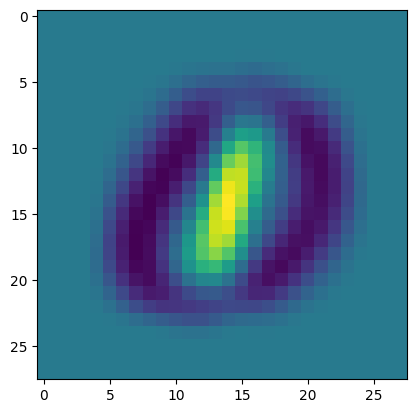

In [42]:
#------TRAINING CODE --------------
def gaussianClassifierWithIdentityCovariance(Xtrain,ytrain):
    # YOUR CODE HERE (3.)
    X1 = Xtrain[ytrain == 0]
    X2 = Xtrain[ytrain == 1]
    # means
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)
    # priors
    p1 = X1.shape[0] / Xtrain.shape[0]
    p2 = X2.shape[0] / Xtrain.shape[0]
    w = mu2 - mu1
    w0 = -0.5 * (np.dot(mu2, mu2) - np.dot(mu1, mu1)) + np.log(p2 / p1)
    a = np.hstack((w, w0))
    return a

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithIdentityCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

# testing to verify results
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB()
# gnb.fit(X_train, y_train)
# train_predictions = gnb.predict(X_train)
# val_predictions = gnb.predict(X_val)
# test_predictions = gnb.predict(X_test)
# train_misclassifications = np.sum(train_predictions != y_train)
# val_misclassifications = np.sum(val_predictions != y_val)
# test_misclassifications = np.sum(test_predictions != y_test)
# print(train_misclassifications)
# print(val_misclassifications)
# print(test_misclassifications)

## Define and test gaussianClassifierWithCommonCovariance 

Mis-classifications = 43 out of 8897 equivalent to 0.48330898055524335 %
Mis-classifications = 10 out of 1449 equivalent to 0.6901311249137336 %
Mis-classifications = 26 out of 4434 equivalent to 0.5863779882724403 %


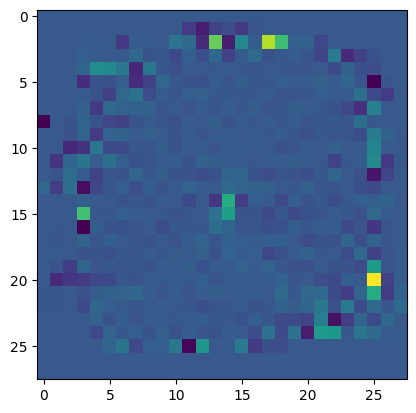

In [43]:
#------TRAINING CODE --------------
def gaussianClassifierWithCommonCovariance(Xtrain,ytrain):
    # YOUR CODE HERE (4.)
    X1 = Xtrain[ytrain == 0]
    X2 = Xtrain[ytrain == 1]
    # means
    mu1 = np.mean(X1, axis=0)
    mu2 = np.mean(X2, axis=0)
    # priors
    p1 = X1.shape[0] / Xtrain.shape[0]
    p2 = X2.shape[0] / Xtrain.shape[0]

    cov1 = np.cov(X1, rowvar=False)
    cov2 = np.cov(X2, rowvar=False)
    sigma = (p1 * cov1 + p2 * cov2)
    sigma += np.eye(sigma.shape[0]) * 1
    
    sigma_inv = np.linalg.inv(sigma)

    w = np.dot(sigma_inv, mu2 - mu1)
    w0 = (-0.5 * (np.dot(mu2, np.dot(sigma_inv, mu2)) - np.dot(mu1, np.dot(sigma_inv, mu1))) + np.log(p2 / p1))
    a = np.hstack((w, w0))
    return a
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithCommonCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


## Define and test logisticRegression 

You may choose the step size as 1e-4. You can try changing it.

Use the expit() function from scipy.special.expit to implement sigmoid without overflow errors 

Mis-classifications = 2 out of 8897 equivalent to 0.022479487467685737 %
Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 5 out of 4434 equivalent to 0.11276499774470004 %


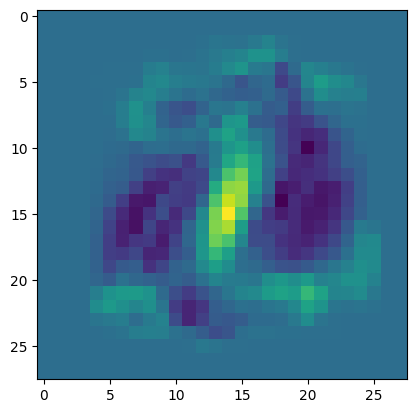

In [44]:
def logisticRegression(Xtrain,ytrain,iterations=100,step_size=1e-4,verbose=False):
    # YOUR CODE HERE (5.)
    X_bias = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))
    a = np.zeros(Xtrain.shape[1] + 1)
    
    for i in range(iterations):
        z = np.dot(X_bias, a)
        predictions = expit(z)

        gradient = np.dot(X_bias.T, (predictions - ytrain)) / ytrain.size
        a -= step_size * gradient

        if verbose and i % (iterations // 10) == 0:
            loss = -np.mean(ytrain * np.log(predictions + 1e-8) + (1 - ytrain) * np.log(1 - predictions + 1e-8))
            print(f"Iteration {i}: Loss = {loss:.6f}")
    
    return a
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegression(X_train,y_train,iterations=500,verbose=False)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


Mis-classifications = 2 out of 8897 equivalent to 0.022479487467685737 %
Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 5 out of 4434 equivalent to 0.11276499774470004 %


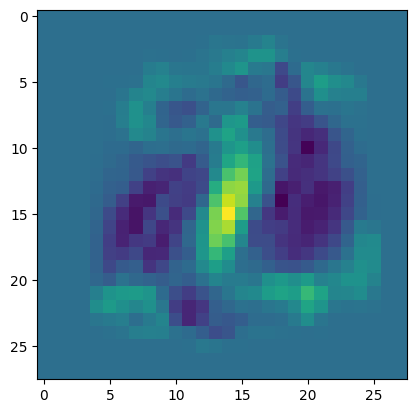

In [45]:
def logisticRegressionWithRegularization(Xtrain,ytrain,iterations=100,step_size=1e-4,lam=1,verbose=False):
    # YOUR CODE HERE (6.)
    X_bias = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))

    a = np.zeros(Xtrain.shape[1] + 1)

    for i in range(iterations):
        z = np.dot(X_bias, a)
        predictions = expit(z)
        gradient = np.dot(X_bias.T, (predictions - ytrain)) / ytrain.size
        regularization = lam * a
        regularization[-1] = 0
        a -= step_size * (gradient + regularization)

        if verbose and i % (iterations // 10) == 0:
            loss = (-np.mean(ytrain * np.log(predictions + 1e-8) + (1 - ytrain) * np.log(1 - predictions + 1e-8)) +
                    (lam / (2 * ytrain.size)) * np.sum(a[:-1] ** 2))
            print(f"Iteration {i}: Loss = {loss:.6f}")

    return a
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=1)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)

In [46]:
def optimizeHyperparameters(Xtrain,ytrain, Xval, yval, Xtest, ytest, lambdas, iterations=500, step_size=1e-4):
    # YOUR CODE HERE (7.)
    lamopt = None
    lowest_misclassifications = float('inf')

    for lam in lambdas:
        a = logisticRegressionWithRegularization(Xtrain, ytrain, iterations=iterations, step_size=step_size, lam=lam)
        misclassifications = testLinearClassifier(a,Xval,yval)
        if misclassifications < lowest_misclassifications:
            lowest_misclassifications = misclassifications
            lamopt = lam

    a4 = logisticRegressionWithRegularization(Xtrain, ytrain, iterations=iterations, step_size=step_size, lam=lamopt)
    Xtest_bias = np.hstack((Xtest, np.ones((Xtest.shape[0], 1))))
    test_predictions = (expit(np.dot(Xtest_bias, a4)) >= 0.5).astype(int)
    test_accuracy = np.mean(test_predictions == ytest)

    return lamopt, a4, (test_accuracy * 100)  

lambdas = [0.01, 0.1, 1, 10, 100]
# lambdas = [100, 10, 1, 0.1, 0.01]
lamopt, a4, test_accuracy = optimizeHyperparameters(X_train, y_train, X_val, y_val, X_test, y_test, lambdas)
print("Optimal λ:", lamopt)
print("Test Accurary:", test_accuracy)

Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 0 out of 1449 equivalent to 0.0 %
Optimal λ: 100
Test Accurary: 99.86468200270636


# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW

In [47]:
def compareClassifiers(Xtrain, ytrain, Xval, yval, Xtest, ytest, lambdas, iterations=500, step_size=1e-4):
    a1 = gaussianClassifierWithIdentityCovariance(Xtrain, ytrain)
    misclassifications_a1 = testLinearClassifier(a1, Xtest, ytest)

    a2 = gaussianClassifierWithCommonCovariance(Xtrain, ytrain)
    misclassifications_a2 = testLinearClassifier(a2, Xtest, ytest)

    a3 = logisticRegression(Xtrain, ytrain, iterations=iterations, step_size=step_size)
    misclassifications_a3 = testLinearClassifier(a3, Xtest, ytest)

    lamopt, a4, test_accuracy = optimizeHyperparameters(Xtrain, ytrain, Xval, yval, Xtest, ytest, lambdas, iterations=iterations, step_size=step_size)
    misclassifications_a4 = testLinearClassifier(a4, Xtest, ytest)

    # results
    print("\nPerformance Summary:")
    print(f"Gaussian Classifier (Identity Covariance, a1): {misclassifications_a1} misclassifications")
    print(f"Gaussian Classifier (Common Covariance, a2): {misclassifications_a2} misclassifications")
    print(f"Logistic Regression (a3): {misclassifications_a3} misclassifications")
    print(f"Regularized Logistic Regression (a4, λ={lamopt}): {misclassifications_a4} misclassifications")
    
    return {
        "a1_misclassifications": misclassifications_a1,
        "a2_misclassifications": misclassifications_a2,
        "a3_misclassifications": misclassifications_a3,
        "a4_misclassifications": misclassifications_a4,
        "a4_lambda_optimal": lamopt,
        "a4_test_accuracy": test_accuracy,
    }


lambdas = [0.01, 0.1, 1, 10, 100]
results = compareClassifiers(X_train, y_train, X_val, y_val, X_test, y_test, lambdas)
print(results)

Mis-classifications = 36 out of 4434 equivalent to 0.8119079837618403 %
Mis-classifications = 26 out of 4434 equivalent to 0.5863779882724403 %
Mis-classifications = 5 out of 4434 equivalent to 0.11276499774470004 %
Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 1 out of 1449 equivalent to 0.06901311249137336 %
Mis-classifications = 0 out of 1449 equivalent to 0.0 %
Mis-classifications = 6 out of 4434 equivalent to 0.13531799729364005 %

Performance Summary:
Gaussian Classifier (Identity Covariance, a1): 36 misclassifications
Gaussian Classifier (Common Covariance, a2): 26 misclassifications
Logistic Regression (a3): 5 misclassifications
Regularized Logistic Regression (a4, λ=100): 6 misclassifications
{'a1_misclassifications': 36, 'a2_misclassifications': 26, 'a3_misclassifications': 5, 'a4_miscla

# Component 2

1. Load the MNIST dataset. Split this dataset into training (70%), validation (10%), and test dataset
(20%).

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

Xtrain = X
ytrain = y

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)

In [49]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]

2. Develop a python function called gaussianMultiChannelClassifier

Matrix A2 shape: (785, 10)


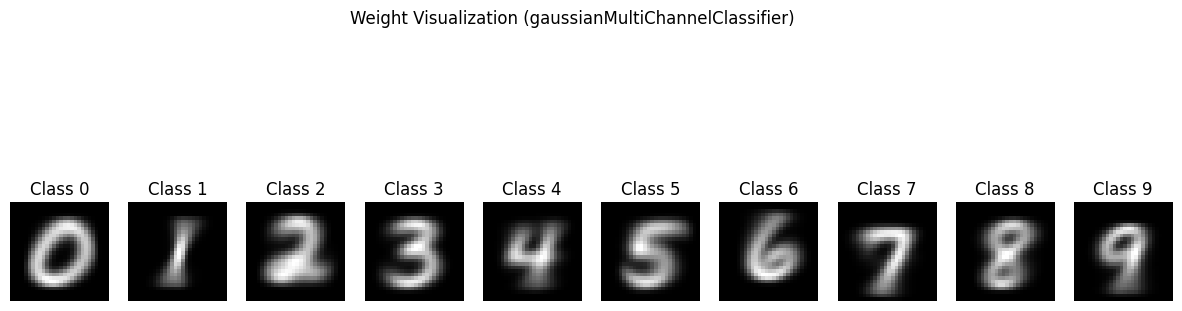

In [50]:
#------TRAINING CODE --------------
def gaussianMultiChannelClassifier(Xtrain, ytrain):
    n_classes = len(np.unique(ytrain))
    n_features = Xtrain.shape[1]
    A1 = np.zeros((n_features + 1, n_classes))

    for i in range(n_classes):
        X_i = Xtrain[ytrain == i]
        mu_i = np.mean(X_i, axis=0)
        prior_i = X_i.shape[0] / Xtrain.shape[0]
        w = mu_i  # Σ = I -> w = μ_i
        w0 = -0.5 * np.dot(mu_i, mu_i) + np.log(prior_i)
        A1[:-1, i] = w
        A1[-1, i] = w0

    return A1

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
A1 = gaussianMultiChannelClassifier(X_train, y_train)
print("Matrix A2 shape:", A1.shape)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    weights = A1[:-1, i]
    image = np.reshape(weights, (28, 28))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.suptitle("Weight Visualization (gaussianMultiChannelClassifier)")
plt.show()

3. Develop a python function called logisticRegressionMultiClassClassifier

Matrix A2 shape: (785, 10)


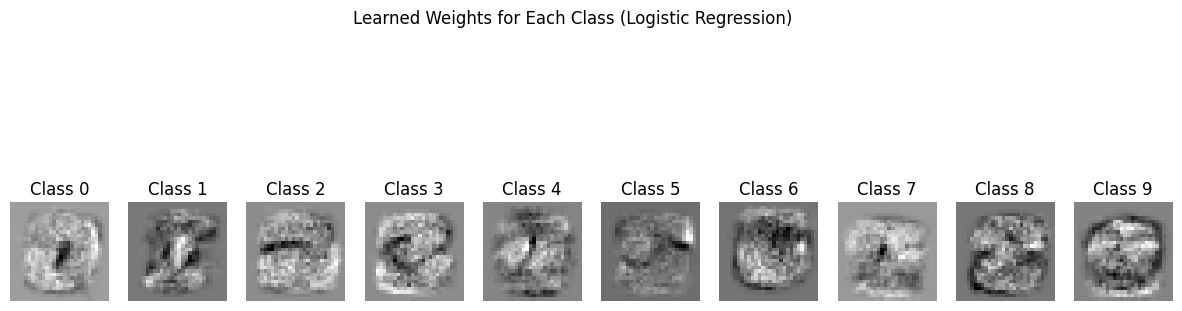

In [51]:
#------TRAINING CODE --------------
def logisticRegressionMultiClassClassifier(Xtrain, ytrain, iterations=1000, step_size=1e-3):
    n_samples, n_features = Xtrain.shape
    n_classes = len(np.unique(ytrain))
    X_bias = np.hstack((Xtrain, np.ones((n_samples, 1))))
    Y_onehot = np.zeros((n_samples, n_classes))
    Y_onehot[np.arange(n_samples), ytrain.astype(int)] = 1
    A2 = np.zeros((n_features + 1, n_classes))

    for _ in range(iterations):
        scores = np.dot(X_bias, A2)
        
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        gradient = np.dot(X_bias.T, (probabilities - Y_onehot)) / n_samples
        A2 -= step_size * gradient

    return A2

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
A2 = logisticRegressionMultiClassClassifier(X_train, y_train)
print("Matrix A2 shape:", A2.shape)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    weights = A2[:-1, i]
    image = np.reshape(weights, (28, 28))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.suptitle("Learned Weights for Each Class (Logistic Regression)")
plt.show()

4. Develop a python function called logisticRegressionMultiClassClassifierWithRegularization

Matrix A3 shape: (785, 10)


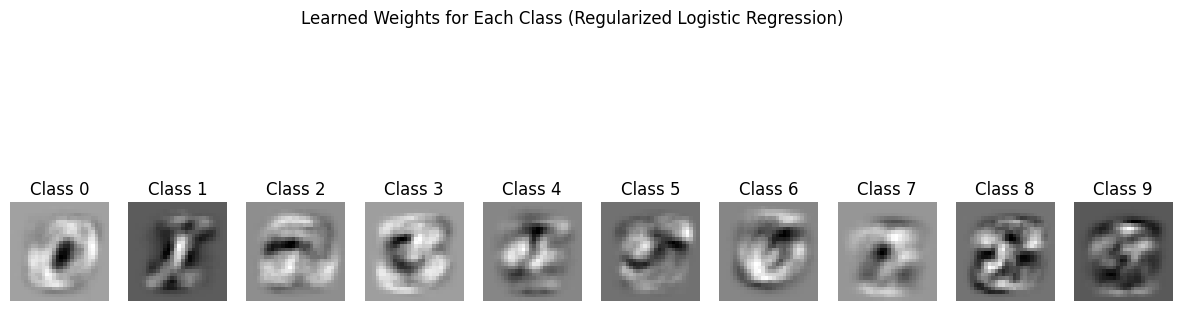

In [52]:
#------TRAINING CODE --------------
def logisticRegressionMultiClassClassifierWithRegularization(Xtrain, ytrain, lam = 0.1, iterations=100, step_size=1e-3):
    n_samples, n_features = Xtrain.shape
    n_classes = len(np.unique(ytrain))
    X_bias = np.hstack((Xtrain, np.ones((n_samples, 1))))
    Y_onehot = np.zeros((n_samples, n_classes))
    Y_onehot[np.arange(n_samples), ytrain.astype(int)] = 1
    A3 = np.zeros((n_features + 1, n_classes))
    
    for _ in range(iterations):
        scores = np.dot(X_bias, A3)
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
        probabilities = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        gradient = np.dot(X_bias.T, (probabilities - Y_onehot)) / n_samples
        gradient[:-1] += lam * A3[:-1]
        A3 -= step_size * gradient

    return A3

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
A3 = logisticRegressionMultiClassClassifierWithRegularization(X_train, y_train, lam=0.1)
print("Matrix A3 shape:", A3.shape)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    weights = A3[:-1, i]
    image = np.reshape(weights, (28, 28))
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.suptitle("Learned Weights for Each Class (Regularized Logistic Regression)")
plt.show()


5. Write a function Optimize_MC_Hyperparameters to determine the optimal λ of logisticRegressionMultiClassClassifierWithRegularization.

In [53]:
#------TRAINING CODE --------------
def Optimize_MC_Hyperparameters(Xtrain, ytrain, Xval, yval, lambdas, iterations=100, step_size=1e-3):

    best_lambda = None
    lowest_misclassifications = float('inf')

    for lam in lambdas:
        A3 = logisticRegressionMultiClassClassifierWithRegularization(
            Xtrain, ytrain, lam=lam, iterations=iterations, step_size=step_size
        )
        
        Xval_bias = np.hstack((Xval, np.ones((Xval.shape[0], 1))))
        scores = np.dot(Xval_bias, A3)
        predictions = np.argmax(scores, axis=1)
        misclassifications = np.sum(predictions != yval)
        
        if misclassifications < lowest_misclassifications:
            lowest_misclassifications = misclassifications
            best_lambda = lam

    A4 = logisticRegressionMultiClassClassifierWithRegularization(
        Xtrain, ytrain, lam=best_lambda, iterations=iterations, step_size=step_size
    )
    
    print(f"Best Lambda: {best_lambda}")
    return A4

#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
lambdas = [0.01, 0.1, 1, 10, 100]
A4 = Optimize_MC_Hyperparameters(X_train, y_train, X_val, y_val, lambdas)
print("Matrix A4 shape:", A4.shape)

Best Lambda: 1
Matrix A4 shape: (785, 10)


6. Write a function testLinearMCClassifier to test the performance of a multiclass classifier specified by its weights A.

In [54]:
def testLinearMCClassifier(A, X, y):
    Xtest_bias = np.hstack((X, np.ones((X.shape[0], 1))))
    scores = np.dot(Xtest_bias, A)
    predictions = np.argmax(scores, axis=1)
    misclassifications = np.sum(predictions != y)
    print(f"Mis-classifications = {misclassifications} out of {y.size} equivalent to {misclassifications/(y.size) * 100} %")
    return misclassifications


7. Write a script that would compare the performance all the above algorithms on the test subset.

In [55]:
# Each prints results out by training, validation, and then test data
# A1
print("A1")
testLinearMCClassifier(A1, X_train, y_train)
testLinearMCClassifier(A1, X_val, y_val)
testLinearMCClassifier(A1, X_test, y_test)
# A2
print("A2")
testLinearMCClassifier(A2, X_train, y_train)
testLinearMCClassifier(A2, X_val, y_val)
testLinearMCClassifier(A2, X_test, y_test)
# A3
print("A3")
testLinearMCClassifier(A3, X_train, y_train)
testLinearMCClassifier(A3, X_val, y_val)
testLinearMCClassifier(A3, X_test,y_test)
# A4
print("A4")
testLinearMCClassifier(A4, X_train, y_train)
testLinearMCClassifier(A4, X_val, y_val)
testLinearMCClassifier(A4, X_test, y_test)

A1
Mis-classifications = 7986 out of 42139 equivalent to 18.95156505849688 %
Mis-classifications = 1304 out of 6861 equivalent to 19.005975805276197 %
Mis-classifications = 3975 out of 21000 equivalent to 18.928571428571427 %
A2
Mis-classifications = 3616 out of 42139 equivalent to 8.581124374095255 %
Mis-classifications = 708 out of 6861 equivalent to 10.319195452557937 %
Mis-classifications = 2083 out of 21000 equivalent to 9.91904761904762 %
A3
Mis-classifications = 6099 out of 42139 equivalent to 14.473528085621396 %
Mis-classifications = 1017 out of 6861 equivalent to 14.822912111937036 %
Mis-classifications = 3139 out of 21000 equivalent to 14.947619047619048 %
A4
Mis-classifications = 3761 out of 42139 equivalent to 8.925223664538787 %
Mis-classifications = 669 out of 6861 equivalent to 9.75076519457805 %
Mis-classifications = 2033 out of 21000 equivalent to 9.68095238095238 %


2033

# Component 3

1. Load the MNIST dataset. Split this dataset into training (70%), validation (10%), and test dataset
(20%).

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change the conditions below to compare between other two digits.
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)

In [57]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]

2. Use a linear kernel support vector machine to classify the above data.

- Extract the support vectors and display them as 28x28 images. For the 0-1 classification, you
would get 76 support vectors, which can be displayed as 63 images. These are the hardest images
to classify.

Number of support vectors: 69


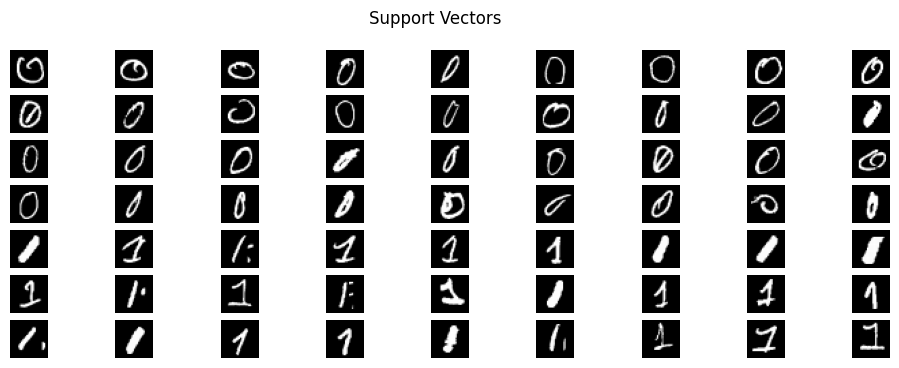

In [58]:
model = SVC(kernel='linear', C=1E10)
model.fit(X_train, y_train)

support_vectors = model.support_vectors_
n_support = len(support_vectors)
print(f"Number of support vectors: {n_support}")

fig, axes = plt.subplots(7, 9, figsize=(12, 4))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(support_vectors[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.suptitle("Support Vectors")
plt.show()

- Plot the dual coefficients or Lagrange multipliers using the attribute `dual_coef_`, which corresponds to the weights for the support vectors.

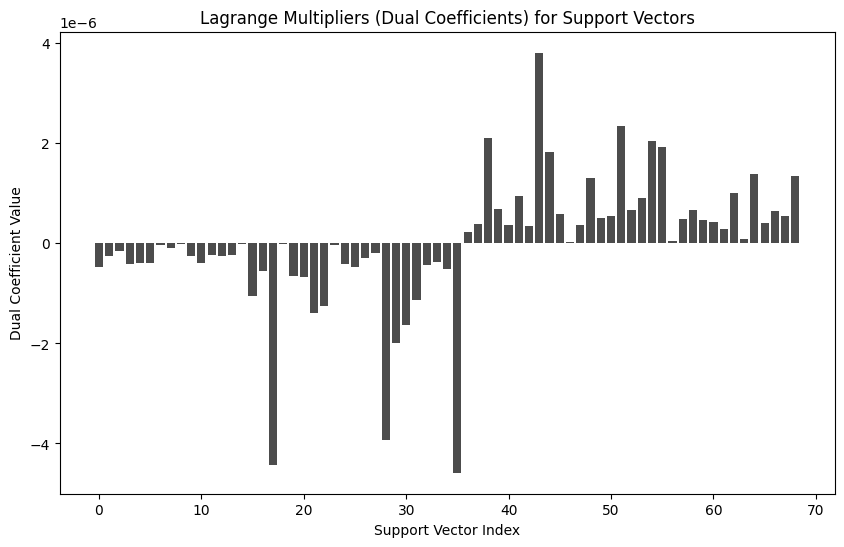

In [59]:
dual_coef = model.dual_coef_[0] 
support_indices = model.support_

plt.figure(figsize=(10, 6))
plt.bar(range(len(dual_coef)), dual_coef, color='black', alpha=0.7)
plt.xlabel("Support Vector Index")
plt.ylabel("Dual Coefficient Value")
plt.title("Lagrange Multipliers (Dual Coefficients) for Support Vectors")
plt.show()

- Use the `decision_function` function of the SVC to compute the value of the discriminant at the
76 support vectors and plot them. The above function computes the discriminant for an arbitrary
input vector. Explain why you get such a plot?

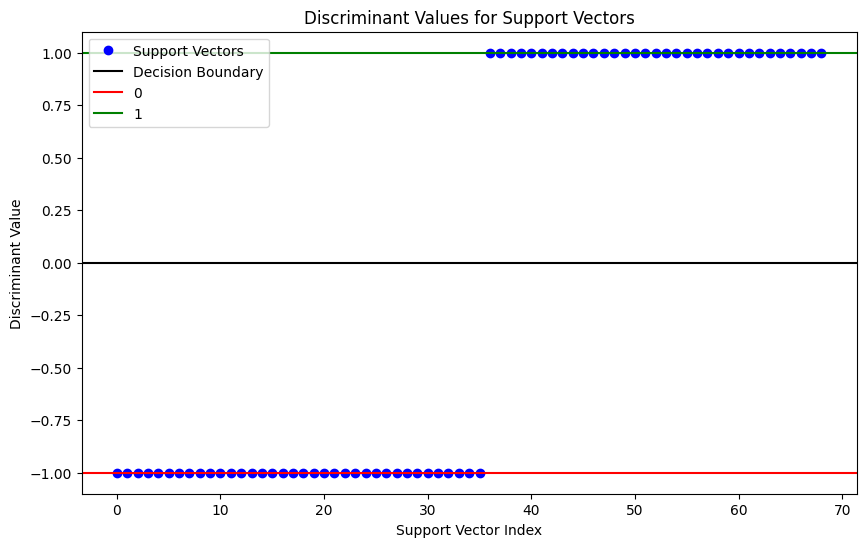

'The plot looks like this becasue it takes in all the support vectors and then the function make a determination of each support vector and classifies it as either 0 (red line) or 1 (green line).'

In [60]:
decision_values = model.decision_function(support_vectors)

plt.figure(figsize=(10, 6))
plt.plot(range(len(decision_values)), decision_values, 'o', color='blue', label='Support Vectors')
plt.axhline(0, color='black', label='Decision Boundary')
plt.axhline(-1, color='red', label='0')
plt.axhline(1, color='green', label='1')
plt.xlabel("Support Vector Index")
plt.ylabel("Discriminant Value")
plt.title("Discriminant Values for Support Vectors")
plt.legend()
plt.show()

# Reason for why our plot looks this way
"""The plot looks like this becasue it takes in all the support vectors and then the function make a determination of each support vector and classifies it as either 0 (red line) or 1 (green line).""" 


- Display the w vector of the classifier using the attribute `coef_` as an image and report the intercept
w0

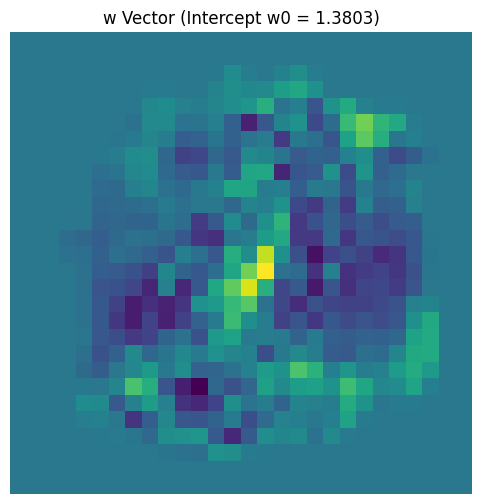

Intercept w0 = 1.3802820778590177


In [62]:
w = model.coef_.reshape(28, 28)
w0 = model.intercept_[0]

plt.figure(figsize=(6, 6))
plt.imshow(w, cmap='viridis')
plt.title(f"w Vector (Intercept w0 = {w0:.4f})")
plt.axis('off')
plt.show()

print(f"Intercept w0 = {w0}")

- Reduce the regularization parameter, denoted by C to 1e-8 and repeat the above. What happens to the number of support vectors? What happens to the w vector? Explain.

Number of support vectors: 487


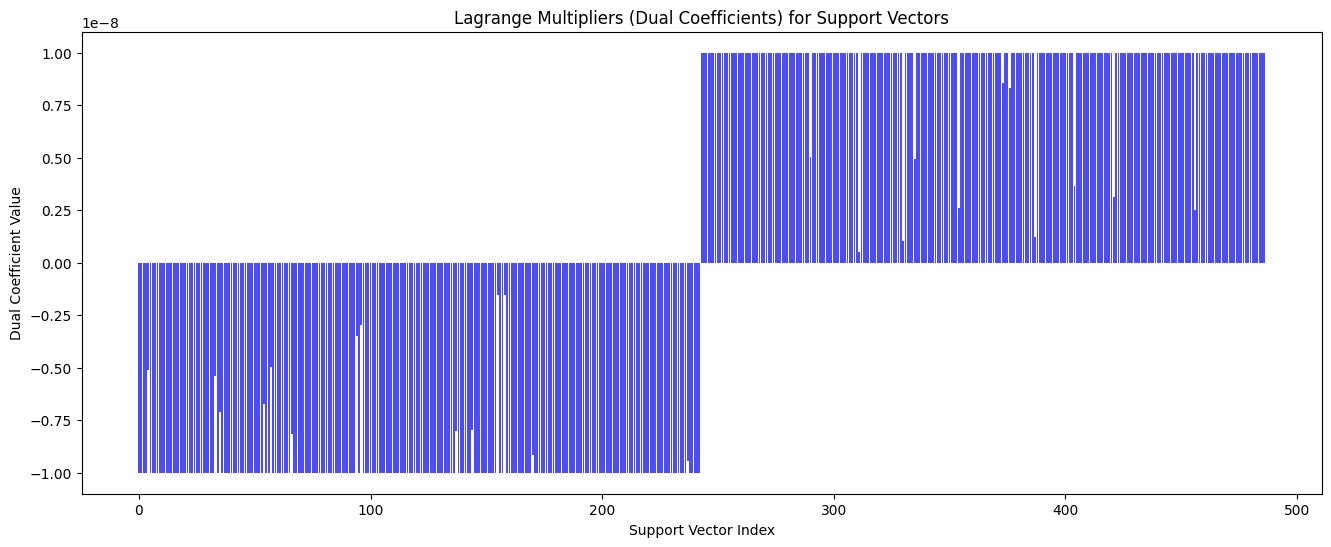

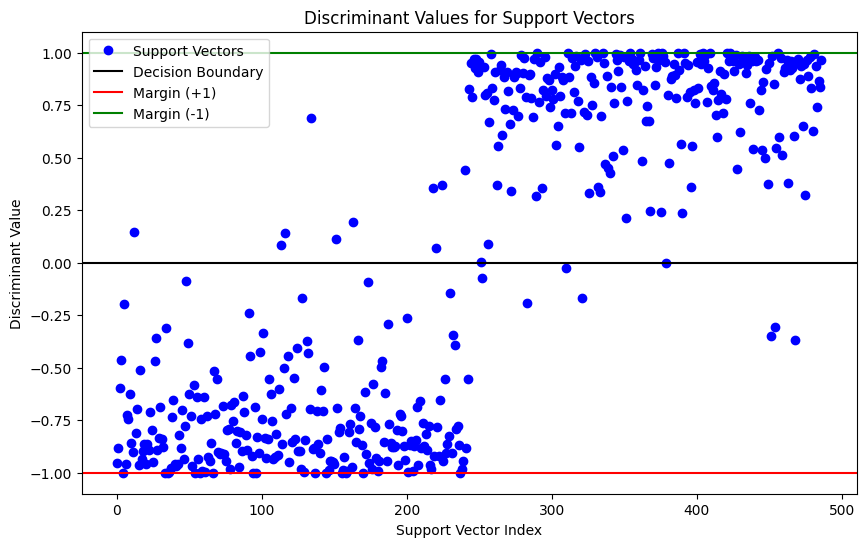


The plot looks like this becasue it takes in all the support vectors and then the function make a determination 
of each support vector and classifies it as either 0 (red line) or 1 (green line).



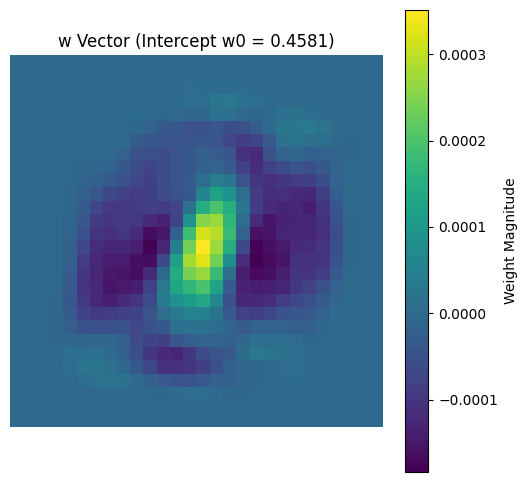

Intercept w0 = 0.4580987162477619

The numnber of support vectors drastically increases.
Then the w vector becomes a bit clearer on the visualization of the decision boundary between 0 and 1.



In [63]:
model = SVC(kernel='linear', C=1E-8)
model.fit(X_train, y_train)

support_vectors = model.support_vectors_
n_support = len(support_vectors)
print(f"Number of support vectors: {n_support}")

# Leaving this out since there are too many graphs to show
# fig, axes = plt.subplots(54, 9, figsize=(12, 4))
# axes = axes.flatten()
# for i, ax in enumerate(axes):
#     ax.imshow(support_vectors[i].reshape(28, 28), cmap='gray')
#     ax.axis('off')
# plt.suptitle("Support Vectors")
# plt.show()

# Dueal coefficients
dual_coef = model.dual_coef_[0] 
support_indices = model.support_
plt.figure(figsize=(16, 6))
plt.bar(range(len(dual_coef)), dual_coef, color='blue', alpha=0.7)
plt.xlabel("Support Vector Index")
plt.ylabel("Dual Coefficient Value")
plt.title("Lagrange Multipliers (Dual Coefficients) for Support Vectors")
plt.show()

# Decision Function
decision_values = model.decision_function(support_vectors)
plt.figure(figsize=(10, 6))
plt.plot(range(len(decision_values)), decision_values, 'o', color='blue', label='Support Vectors')
plt.axhline(0, color='black', label='Decision Boundary')
plt.axhline(-1, color='red', label='Margin (+1)')
plt.axhline(1, color='green', label='Margin (-1)')
plt.xlabel("Support Vector Index")
plt.ylabel("Discriminant Value")
plt.title("Discriminant Values for Support Vectors")
plt.legend()
plt.show()

# Reason for why our plot looks this way
print("""
The plot looks like this becasue it takes in all the support vectors and then the function make a determination 
of each support vector and classifies it as either 0 (red line) or 1 (green line).
""")

# Intercept w0
w = model.coef_.reshape(28, 28)
w0 = model.intercept_[0]

plt.figure(figsize=(6, 6))
plt.imshow(w, cmap='viridis')
plt.colorbar(label="Weight Magnitude")
plt.title(f"w Vector (Intercept w0 = {w0:.4f})")
plt.axis('off')
plt.show()

print(f"Intercept w0 = {w0}")

# Explaination of what happened:
print("""
The numnber of support vectors drastically increases.\nThen the w vector becomes a bit clearer on the visualization of the decision boundary between 0 and 1.
""")


- Using the validation data, determine the optimal value of the regularization parameter. Display the w vector in this case

Optimal C: 0.001
Validation Accuracy for Optimal C: 0.9986


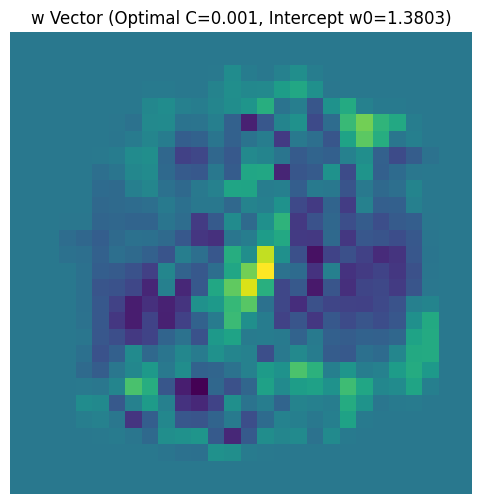

In [64]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
validation_accuracies = []
models = []

# Train SVM for each C and evaluate on the validation set
for C in C_values:
    model = SVC(kernel='linear', C=C)
    model.fit(X_train, y_train)
    models.append(model)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies.append(accuracy)

# Find the optimal C (maximizing accuracy)
optimal_index = np.argmax(validation_accuracies)
optimal_C = C_values[optimal_index]
optimal_model = models[optimal_index]

print(f"Optimal C: {optimal_C}")
print(f"Validation Accuracy for Optimal C: {validation_accuracies[optimal_index]:.4f}")

# Display the w vector for the optimal C
w_optimal = optimal_model.coef_.reshape(28, 28)  # Reshape to image
w0_optimal = optimal_model.intercept_[0]

plt.figure(figsize=(6, 6))
plt.imshow(w_optimal, cmap='viridis')
plt.title(f"w Vector (Optimal C={optimal_C}, Intercept w0={w0_optimal:.4f})")
plt.axis('off')
plt.show()


- Using score, determine the accuracy of the classification in the 0-1 and 2-3 settings

In [65]:
optimal_C = 0.001 # Using C value from previous part
svm_classifier = SVC(kernel="linear", C=optimal_C) 
svm_classifier.fit(X_train, y_train)
best_model = svm_classifier
best_accuracy = svm_classifier.score(X_val, y_val)

print(f"Optimal C: {optimal_C}")
print(f"Validation Accuracy with Optimal C: {(best_accuracy * 100):.4f}%")

# 0-1 classification
accuracy_01 = best_model.score(X_test, y_test)
print(f"Accuracy for 0-1 Classification: {(accuracy_01 * 100):.4f}%")

# 2-3 classification
x2 = X[(y == 2)]
x3 = X[(y == 3)]

Xtrain_23 = np.concatenate((x2, x3), axis=0)
ytrain_23 = np.concatenate((np.zeros(x2.shape[0]), np.ones(x3.shape[0])), axis=0)

X_train_23, X_test_23, y_train_23, y_test_23 = train_test_split(Xtrain_23, ytrain_23, test_size=0.3, random_state=1)
X_train_23, X_val_23, y_train_23, y_val_23 = train_test_split(X_train_23, y_train_23, test_size=0.14, random_state=1)

svm_classifier_23 = SVC(kernel="linear", C=optimal_C)
svm_classifier_23.fit(X_train_23, y_train_23)
accuracy_23 = svm_classifier_23.score(X_test_23, y_test_23)

print(f"Accuracy for 2-3 Classification: {(accuracy_23 * 100):.4f}%")

Optimal C: 0.001
Validation Accuracy with Optimal C: 99.8620%
Accuracy for 0-1 Classification: 99.8421%
Accuracy for 2-3 Classification: 95.7783%


### Two class classification with kernel classifiers
#### Use `poly` and `rbf` kernels to classify the above data.
- Extract the support vectors and display them as 28x28 images in each case

Kernel: poly, Number of support vectors: 256


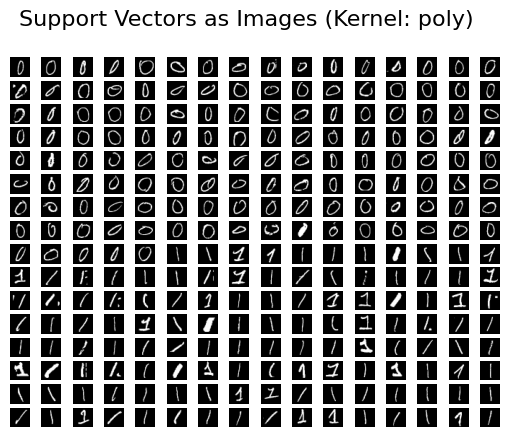

Test Accuracy (Kernel: poly): 99.7970%
Kernel: rbf, Number of support vectors: 194


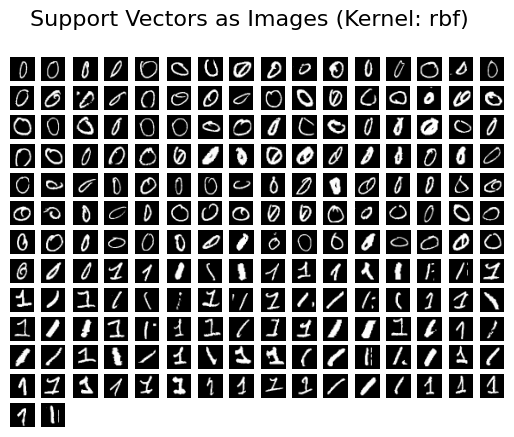

Test Accuracy (Kernel: rbf): 99.9323%


In [66]:
def kernel_svm_with_support_vectors(X, y, class1, class2, kernel, **kernel_params):
    x_class1 = X[(y == class1)]
    x_class2 = X[(y == class2)]
    Xtrain = np.concatenate((x_class1, x_class2), axis=0)
    ytrain = np.concatenate((np.zeros(x_class1.shape[0]), np.ones(x_class2.shape[0])), axis=0)
    
    X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)
    model = SVC(kernel=kernel, **kernel_params)
    model.fit(X_train, y_train)

    support_vectors = model.support_vectors_
    n_support = len(support_vectors)
    print(f"Kernel: {kernel}, Number of support vectors: {n_support}")

    grid_cols = 16
    grid_rows = int(np.ceil(n_support / grid_cols))
    fig, axes = plt.subplots(grid_rows, grid_cols)
    axes = axes.flatten()

    for i, ax in enumerate(axes[:n_support]):
        ax.imshow(support_vectors[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

    for ax in axes[n_support:]:
        ax.axis('off')

    plt.suptitle(f"Support Vectors as Images (Kernel: {kernel})", fontsize=16)
    plt.show()

    accuracy = model.score(X_test, y_test)
    print(f"Test Accuracy (Kernel: {kernel}): {accuracy * 100:.4f}%")
    return model

poly_model = kernel_svm_with_support_vectors(X, y, 0, 1, kernel='poly', degree=3, C=1.0)
rbf_model = kernel_svm_with_support_vectors(X, y, 0, 1, kernel='rbf', C=1.0, gamma='scale')


- Plot the dual coefficients or Lagrange multipliers using the attribute dual_coef_, which corresponds to the weights for the support vectors.

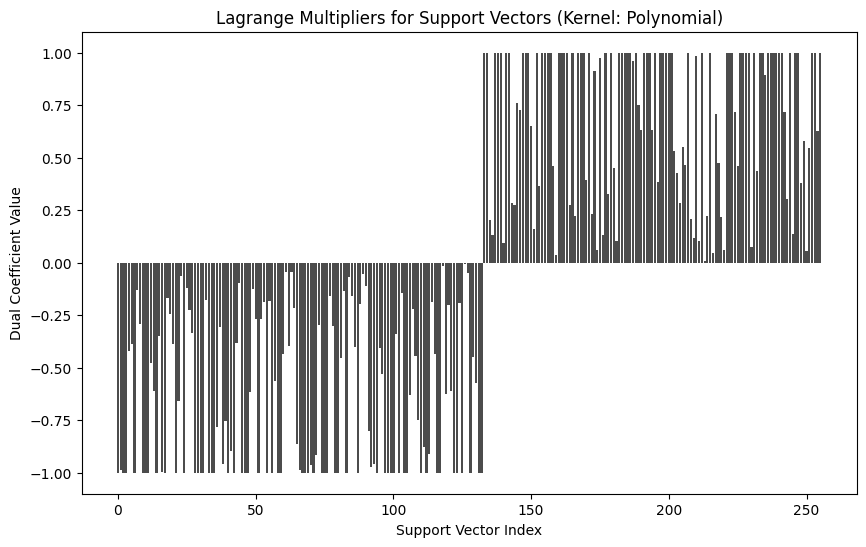

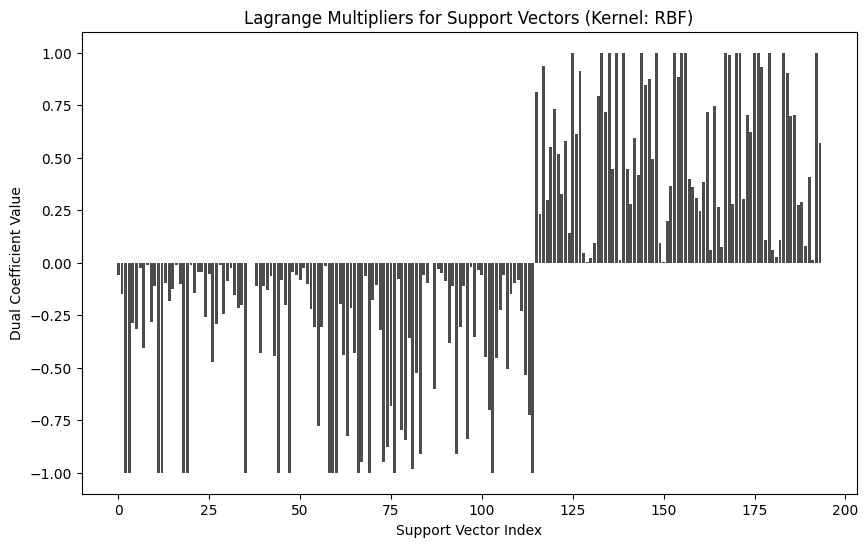

In [67]:
def plot_dual_coefficients(model, kernel_name):
    dual_coef = model.dual_coef_[0]
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(dual_coef)), dual_coef, color='black', alpha=0.7)
    plt.xlabel("Support Vector Index")
    plt.ylabel("Dual Coefficient Value")
    plt.title(f"Lagrange Multipliers for Support Vectors (Kernel: {kernel_name})")
    plt.show()

plot_dual_coefficients(poly_model, "Polynomial")
plot_dual_coefficients(rbf_model, "RBF")

- Use the decision_function function of the SVC to compute the value of the discriminant at the support vectors and plot them. In this case, there is no w vector; the classifier involves the inner-products in high-dimensional space, which requires the evaluation of kernels with all the support vectors.

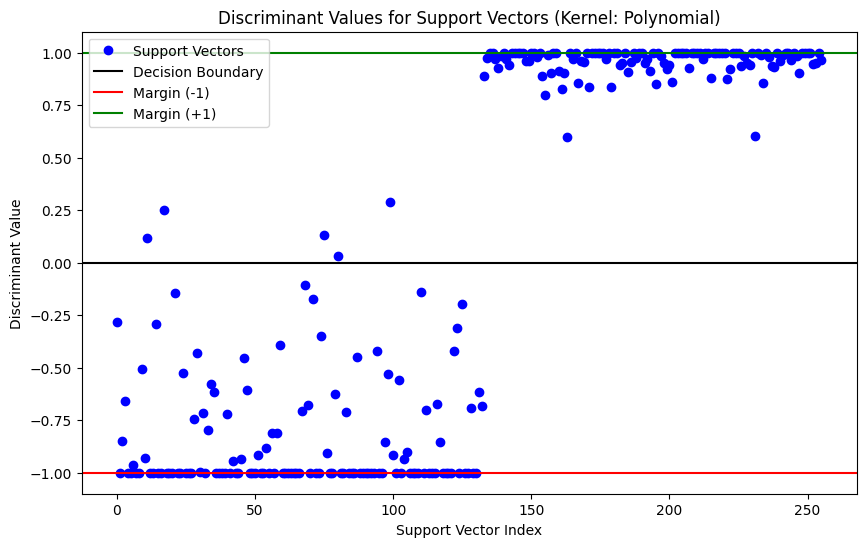

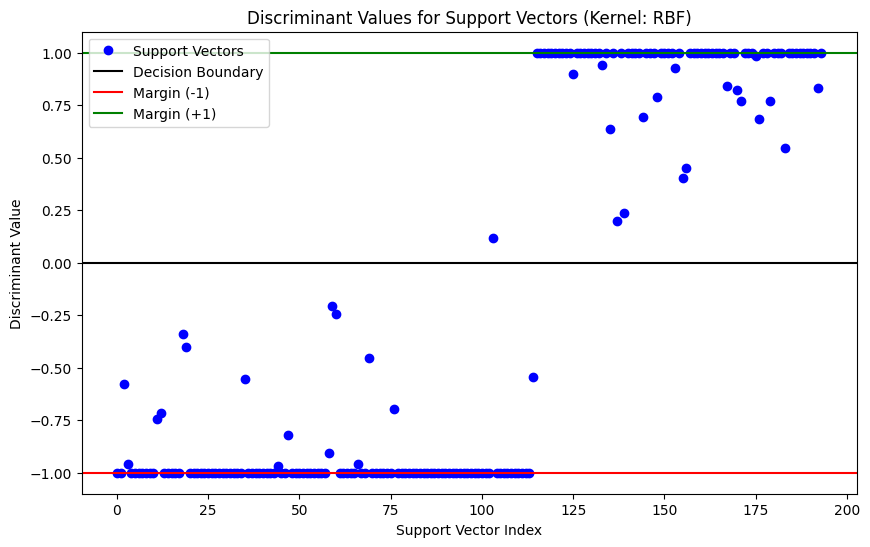

In [68]:
def plot_discriminant_values(model, support_vectors, kernel_name):
    decision_values = model.decision_function(support_vectors)
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(decision_values)), decision_values, 'o', color='blue', label='Support Vectors')
    plt.axhline(0, color='black', label='Decision Boundary')
    plt.axhline(-1, color='red', label='Margin (-1)')
    plt.axhline(1, color='green', label='Margin (+1)')
    plt.xlabel("Support Vector Index")
    plt.ylabel("Discriminant Value")
    plt.title(f"Discriminant Values for Support Vectors (Kernel: {kernel_name})")
    plt.legend()
    plt.show()

plot_discriminant_values(poly_model, poly_model.support_vectors_, "Polynomial")
plot_discriminant_values(rbf_model, rbf_model.support_vectors_, "RBF")

- Using the validation data, determine the optimal value of the regularization parameter. Using score, determine the accuracy of the classification in the 0-1 and 2-3 settings

In [69]:
def optimize_C_kernel(X, y, class1, class2, kernel, C_values, **kernel_params):
    x_class1 = X[(y == class1)]
    x_class2 = X[(y == class2)]
    Xtrain = np.concatenate((x_class1, x_class2), axis=0)
    ytrain = np.concatenate((np.zeros(x_class1.shape[0]), np.ones(x_class2.shape[0])), axis=0)
    
    X_train, X_temp, y_train, y_temp = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    model = SVC(kernel=kernel, **kernel_params)
    model.fit(X_train, y_train)

    validation_accuracies = []
    models = []
    for C in C_values:
        model = SVC(kernel=kernel, C=C, **kernel_params)
        model.fit(X_train, y_train)
        models.append(model)
        accuracy = model.score(X_val, y_val)
        validation_accuracies.append(accuracy)

    optimal_index = np.argmax(validation_accuracies)
    optimal_C = C_values[optimal_index]
    optimal_model = models[optimal_index]

    print(f"Optimal C for classes {class1}-{class2} with {kernel} kernel: {optimal_C}")
    print(f"Validation Accuracy: {validation_accuracies[optimal_index] * 100:.4f}%")
    test_accuracy = optimal_model.score(X_test, y_test)
    print(f"Test Accuracy for classes {class1}-{class2} with {kernel} kernel: {test_accuracy * 100:.4f}%")
    return optimal_model, optimal_C, validation_accuracies[optimal_index], test_accuracy

# ------ Testing kernals code ------
C_values = [1e-3, 1e-2, 1e-1, 1, 10, 100]

print("Polynomial Kernel (0-1 Classification)")
poly_optimal_model_01, poly_optimal_C_01, poly_val_acc_01, poly_test_acc_01 = optimize_C_kernel(
    X, y, 0, 1, kernel='poly', C_values=C_values, degree=3
)
print("Polynomial Kernel (2-3 Classification)")
poly_optimal_model_23, poly_optimal_C_23, poly_val_acc_23, poly_test_acc_23 = optimize_C_kernel(
    X, y, 2, 3, kernel='poly', C_values=C_values, degree=3
)

print("RBF Kernel (0-1 Classification)")
rbf_optimal_model_01, rbf_optimal_C_01, rbf_val_acc_01, rbf_test_acc_01 = optimize_C_kernel(
    X, y, 0, 1, kernel='rbf', C_values=C_values, gamma='scale'
)
print("RBF Kernel (2-3 Classification)")
rbf_optimal_model_23, rbf_optimal_C_23, rbf_val_acc_23, rbf_test_acc_23 = optimize_C_kernel(
    X, y, 2, 3, kernel='rbf', C_values=C_values, gamma='scale'
)


Polynomial Kernel (0-1 Classification)
Optimal C for classes 0-1 with poly kernel: 10
Validation Accuracy: 99.8196%
Test Accuracy for classes 0-1 with poly kernel: 99.7745%
Polynomial Kernel (2-3 Classification)
Optimal C for classes 2-3 with poly kernel: 100
Validation Accuracy: 99.4811%
Test Accuracy for classes 2-3 with poly kernel: 99.1981%
RBF Kernel (0-1 Classification)
Optimal C for classes 0-1 with rbf kernel: 10
Validation Accuracy: 100.0000%
Test Accuracy for classes 0-1 with rbf kernel: 99.9549%
RBF Kernel (2-3 Classification)
Optimal C for classes 2-3 with rbf kernel: 10
Validation Accuracy: 99.4340%
Test Accuracy for classes 2-3 with rbf kernel: 99.1038%


### Multi-class classification

- Load the MNIST dataset. Restrict the dataset to desired number digits (e.g (0,1,2,3)). Split this
dataset into training (70%), validation (10%), and test dataset (20%).

In [70]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

class1Indices = (y==0)
class2Indices = (y==1)
class3Indices = (y==2)
class4Indices = (y==3)

x1 = X[class1Indices]
x2 = X[class2Indices]
x3 = X[class3Indices]
x4 = X[class4Indices]

Xtrain = np.concatenate((x1,x2,x3,x4),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0]),np.full(x3.shape[0], 2),np.full(x4.shape[0], 3)), axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)

In [71]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2

print(len(X_train))
print(len(y_train))
# used sampled data in order to get a response from the models
X_train_sampled = X_train[:5000]
y_train_sampled = y_train[:5000]

Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]

17403
17403


- Determine the optimal linear classifiers using one-versus-rest (ovr) and one-versus-one (ovo) approaches. 
In each case, plot the dual coefficients. The number of dual coefficients will be different in the two different settings. 
Also display the w vectors in each case from the `coef_` attribute.

One-vs-Rest (OvR)


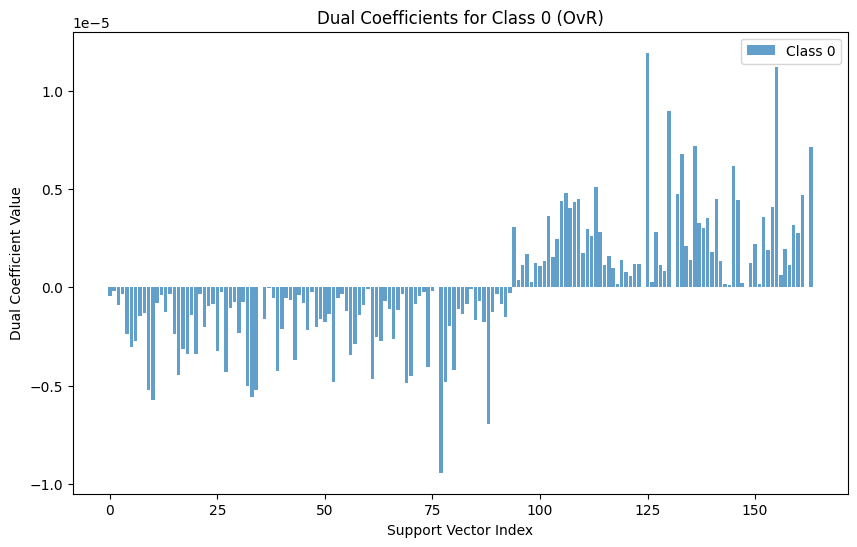

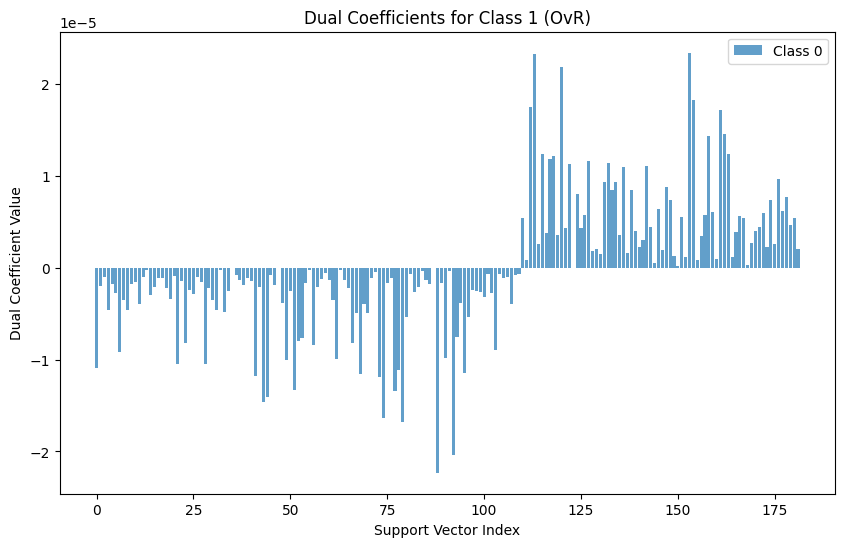

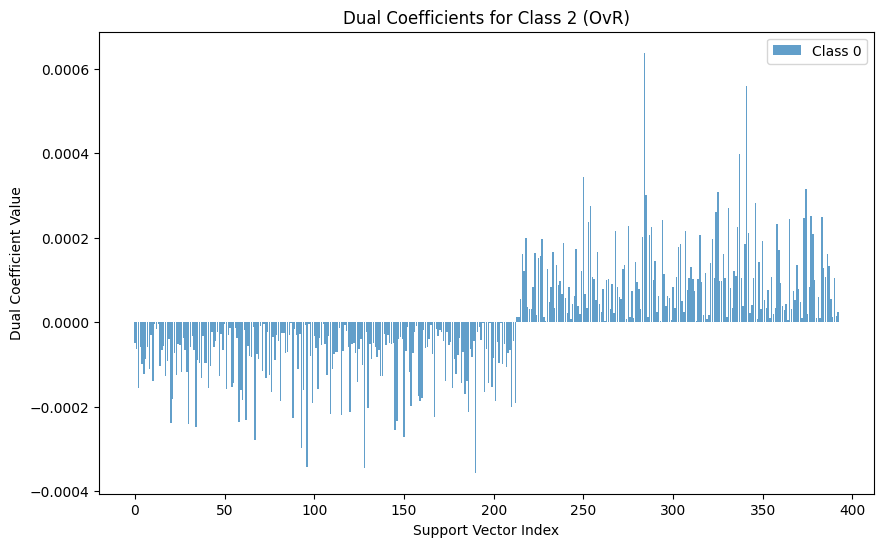

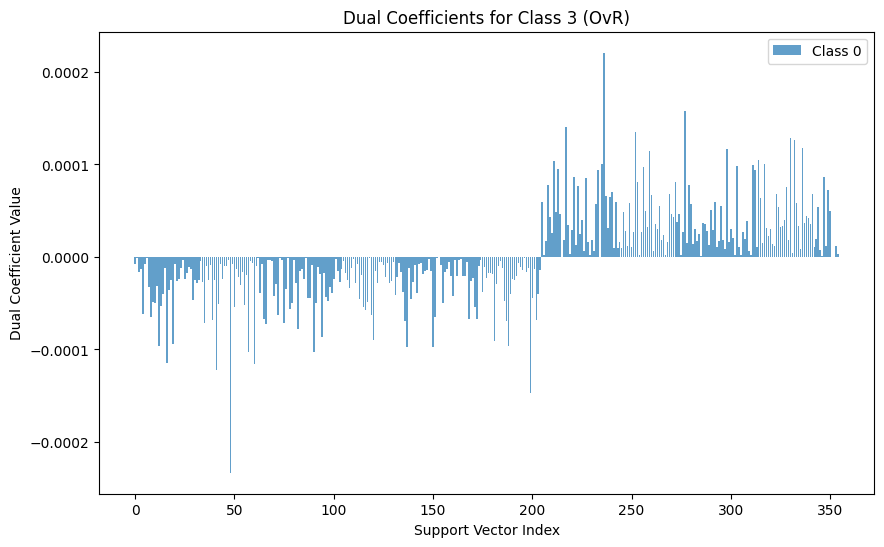

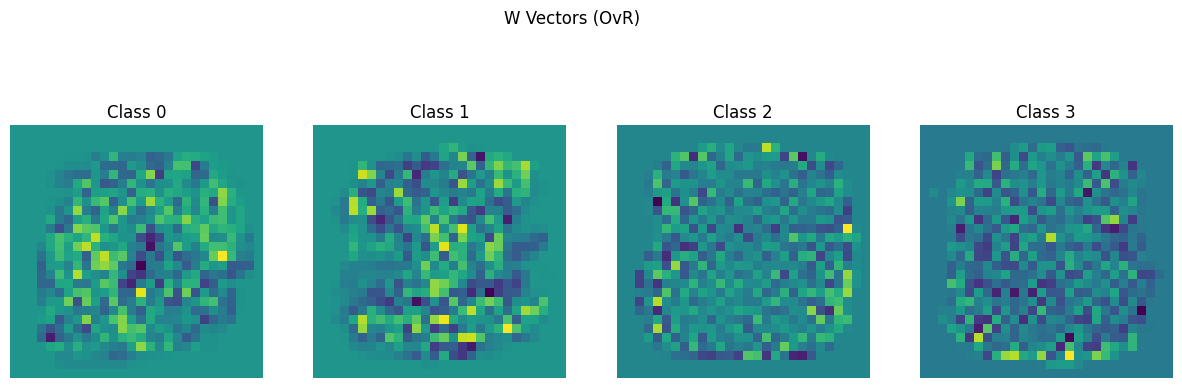

One-vs-One (OvO)


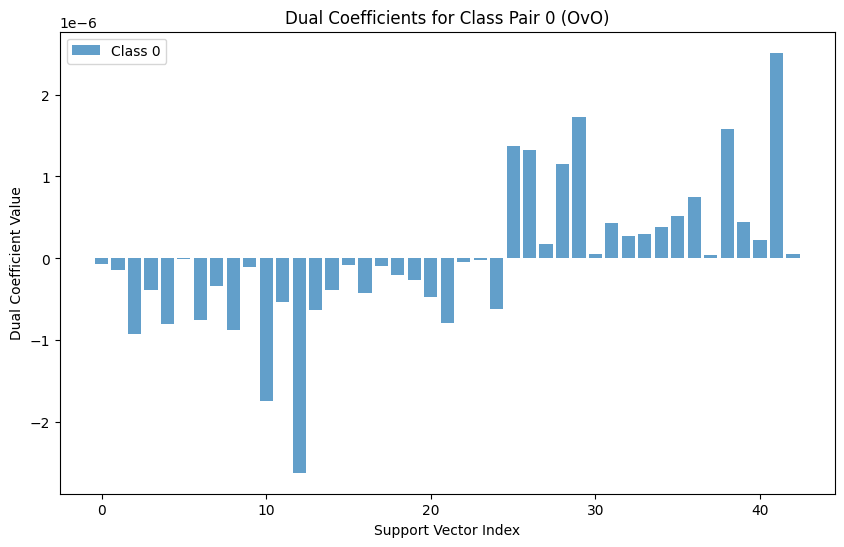

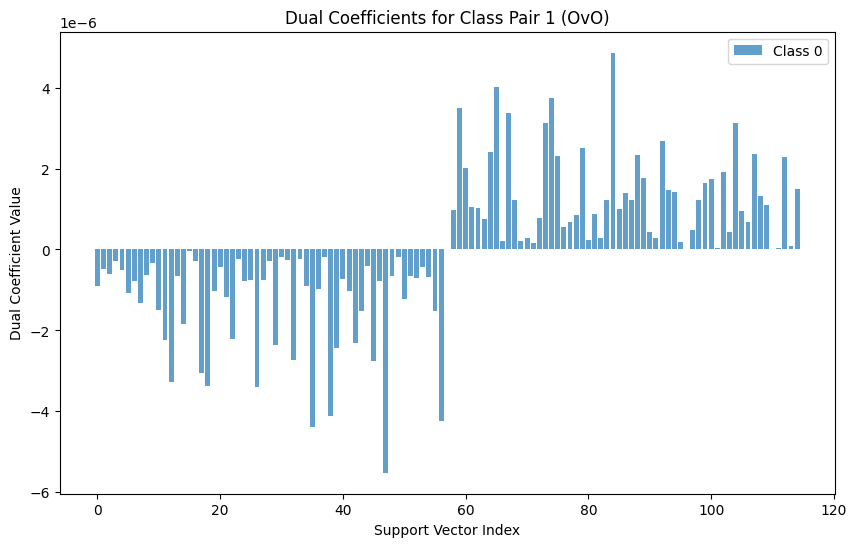

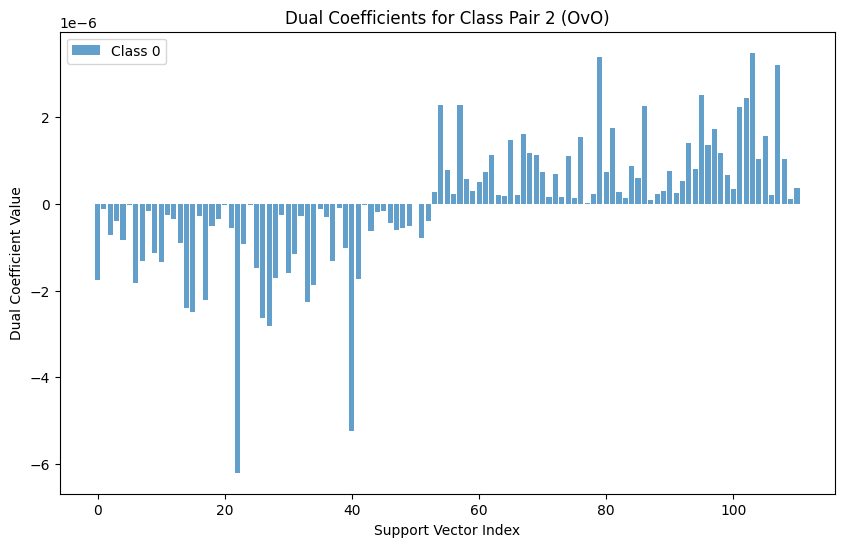

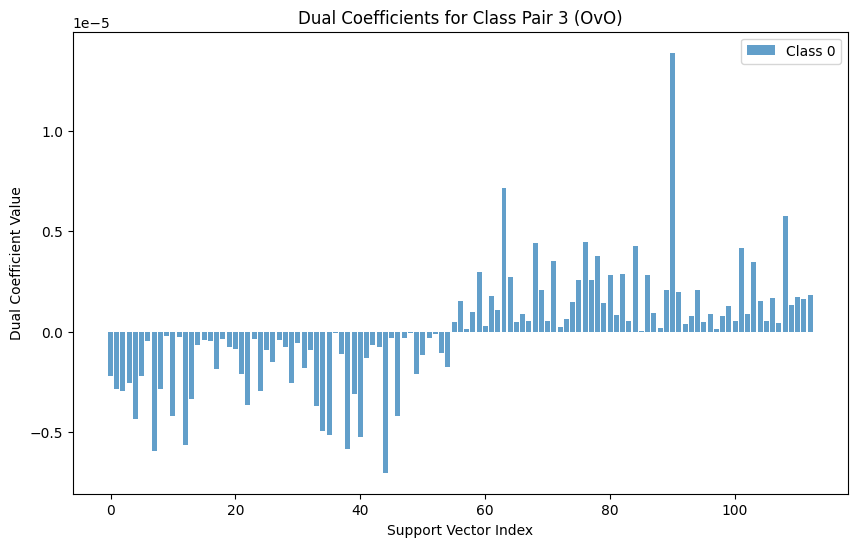

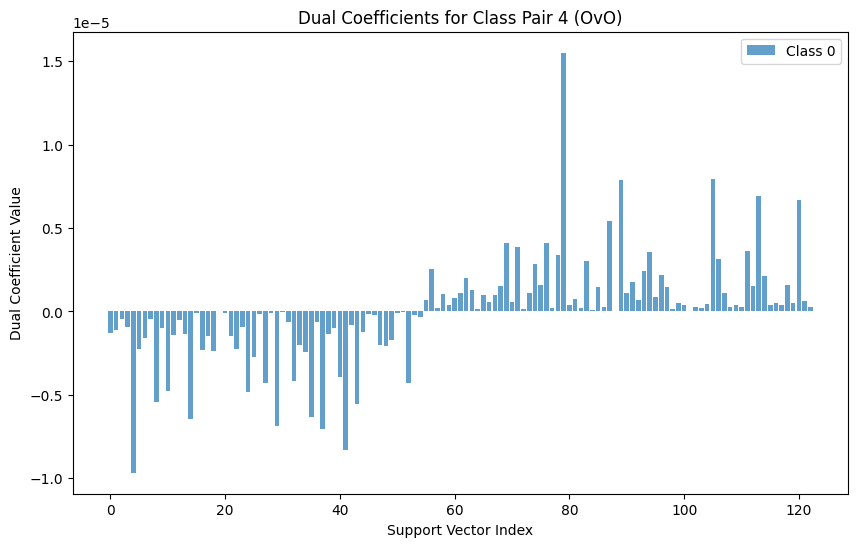

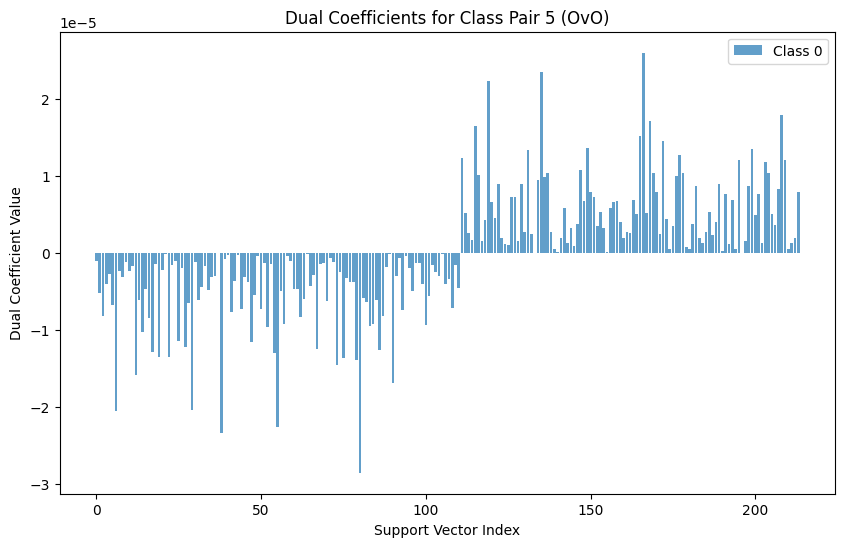

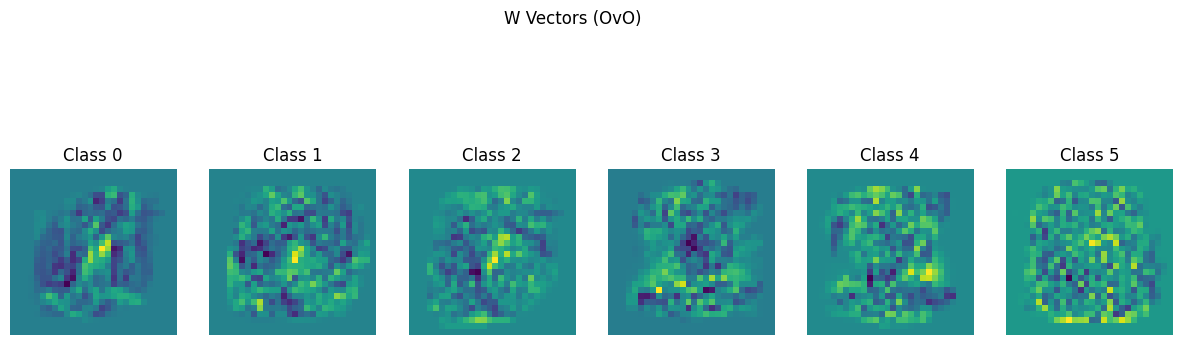

In [72]:
def plot_dual_coefficients(model, title):
    dual_coefs = model.dual_coef_
    plt.figure(figsize=(10, 6))
    for i, coef in enumerate(dual_coefs):
        plt.bar(range(len(coef)), coef, alpha=0.7, label=f"Class {i}")
    plt.xlabel("Support Vector Index")
    plt.ylabel("Dual Coefficient Value")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_w_vectors_ovr(ovr_clf, title):
    estimators = ovr_clf.estimators_
    n_classes = len(estimators)
    fig, axes = plt.subplots(1, n_classes, figsize=(15, 5))
    for i, (ax, model) in enumerate(zip(axes, estimators)):
        if hasattr(model, 'coef_'):
            coef = model.coef_.reshape(28, 28)
            ax.imshow(coef, cmap="viridis")
            ax.axis("off")
            ax.set_title(f"Class {i}")
        else:
            ax.axis("off")
            ax.set_title(f"Class {i} (No Coef_)")
    
    fig.suptitle(title)
    plt.show()


print("One-vs-Rest (OvR)")
ovr_clf = OneVsRestClassifier(SVC(kernel="linear", C=1.0), n_jobs=-1)
ovr_clf.fit(X_train_sampled, y_train_sampled)
ovr_models = ovr_clf.estimators_
# print(f"dual coefficients (OvR): {[model.dual_coef_.shape for model in ovr_models]}")

for i, model in enumerate(ovr_models):
    plot_dual_coefficients(model, title=f"Dual Coefficients for Class {i} (OvR)")
plot_w_vectors_ovr(ovr_clf, title="W Vectors (OvR)")


print("One-vs-One (OvO)")
ovo_clf = OneVsOneClassifier(SVC(kernel="linear", C=1.0), n_jobs=-1)
ovo_clf.fit(X_train_sampled, y_train_sampled)
ovo_models = ovo_clf.estimators_
# print(f"dual coefficients (OvO): {[model.dual_coef_.shape for model in ovo_models]}")

for i, model in enumerate(ovo_models):
    plot_dual_coefficients(model, title=f"Dual Coefficients for Class Pair {i} (OvO)")
plot_w_vectors_ovr(ovo_clf, title="W Vectors (OvO)")


- Determine the optimal regularization parameter and the classification accuracy for the linear classifier.

In [73]:
def optimize_regularization_parameter(X_train, y_train, X_val, y_val, C_values):
    validation_accuracies = []
    models = []

    for C in C_values:
        ovr_clf = OneVsRestClassifier(SVC(kernel="linear", C=C), n_jobs=-1)
        ovr_clf.fit(X_train, y_train)
        models.append(ovr_clf)
        val_accuracy = ovr_clf.score(X_val, y_val)
        validation_accuracies.append(val_accuracy)

    optimal_index = np.argmax(validation_accuracies)
    optimal_C = C_values[optimal_index]
    optimal_model = models[optimal_index]
    
    return optimal_C, optimal_model, validation_accuracies

X_train_sampled, X_val_sampled, y_train_sampled, y_val_sampled = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=1
)

C_values = [1e-3, 1e-2, 1e-1, 1, 10, 100]

optimal_C, optimal_model, validation_accuracies = optimize_regularization_parameter(
    X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, C_values
)

print(f"Optimal C: {optimal_C}")
print("Validation Accuracies for each C:")
for c, acc in zip(C_values, validation_accuracies):
    print(f"C = {c}: Validation Accuracy = {acc * 100:.2f}%")


Optimal C: 0.001
Validation Accuracies for each C:
C = 0.001: Validation Accuracy = 95.60%
C = 0.01: Validation Accuracy = 95.60%
C = 0.1: Validation Accuracy = 95.60%
C = 1: Validation Accuracy = 95.60%
C = 10: Validation Accuracy = 95.60%
C = 100: Validation Accuracy = 95.60%


- Determine the best SVM classifier for the above dataset with all the digits. You can vary the following parameters:
    - Type of the kernel
    - Regularization parameter
    - Degree of the polynomial kernel degree
    - gamma, which is a shape parameter for Gaussian or rbf kernels
    - ovr vs ovo

In [74]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
import numpy as np

# Load the MNIST dataset with all digits (0-9)
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])  # Convert to integer labels

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

print(len(X_train))
print(len(y_train))

# used 10% of data in order to get a quicker response from the models
X_train = X_train[:4900]
y_train = y_train[:4900]
X_test = X_test[:1400]
y_test = y_test[:1400]
X_val = X_val[:700]
y_val = y_val[:700]

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

kernels = ["linear", "poly", "rbf"]
C_values = [1e-3, 1e-2, 1e-1, 1, 10, 100]
degrees = [2, 3, 4]  # For polynomial kernel
gammas = ["scale", "auto", 0.01, 0.1, 1.0]  # For RBF and polynomial kernels
multi_class_strategies = [OneVsRestClassifier, OneVsOneClassifier]
results = []

for strategy in multi_class_strategies:
    for kernel in kernels:
        for C in C_values:
            for degree in (degrees if kernel == "poly" else [None]):
                for gamma in (gammas if kernel in ["poly", "rbf"] else [None]):
                    params = {"kernel": kernel, "C": C}
                    if degree is not None:
                        params["degree"] = degree
                    if gamma is not None:
                        params["gamma"] = gamma
                    
                    try:
                        model = strategy(SVC(**params, random_state=42), n_jobs=-1)
                        model.fit(X_train, y_train)
                        val_accuracy = model.score(X_val, y_val)
                        results.append({
                            "strategy": strategy.__name__,
                            "kernel": kernel,
                            "C": C,
                            "degree": degree,
                            "gamma": gamma,
                            "val_accuracy": val_accuracy,
                            "model": model,
                        })
                        print(f"Evaluated: {strategy.__name__}, kernel={kernel}, C={C}, "
                              f"degree={degree}, gamma={gamma}, val_accuracy={val_accuracy:.4f}")
                    
                    except Exception as e:
                        # to prevent from failing 
                        print(f"Failed for {strategy.__name__}, kernel={kernel}, C={C}, "
                              f"degree={degree}, gamma={gamma} with error: {e}")

best_model_data = max(results, key=lambda x: x["val_accuracy"])
best_model = best_model_data["model"]
print("\nBest Model Configuration:")
for key, value in best_model_data.items():
    if key != "model":
        print(f"{key}: {value}")

test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy of Best Model: {test_accuracy * 100:.2f}%")


49000
49000
Training set size: 4900
Validation set size: 700
Test set size: 1400
Evaluated: OneVsRestClassifier, kernel=linear, C=0.001, degree=None, gamma=None, val_accuracy=0.8343
Evaluated: OneVsRestClassifier, kernel=linear, C=0.01, degree=None, gamma=None, val_accuracy=0.8300
Evaluated: OneVsRestClassifier, kernel=linear, C=0.1, degree=None, gamma=None, val_accuracy=0.8300
Evaluated: OneVsRestClassifier, kernel=linear, C=1, degree=None, gamma=None, val_accuracy=0.8300
Evaluated: OneVsRestClassifier, kernel=linear, C=10, degree=None, gamma=None, val_accuracy=0.8300
Evaluated: OneVsRestClassifier, kernel=linear, C=100, degree=None, gamma=None, val_accuracy=0.8300
Evaluated: OneVsRestClassifier, kernel=poly, C=0.001, degree=2, gamma=scale, val_accuracy=0.8429
Evaluated: OneVsRestClassifier, kernel=poly, C=0.001, degree=2, gamma=auto, val_accuracy=0.9529
Evaluated: OneVsRestClassifier, kernel=poly, C=0.001, degree=2, gamma=0.01, val_accuracy=0.9529
Evaluated: OneVsRestClassifier, kern

In [75]:
# Load the MNIST dataset with all digits (0-9)
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])  # Convert to integer labels

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)


print(len(X_train))
print(len(y_train))

# Best Model Configuration:
# strategy: OneVsOneClassifier
# kernel: rbf
# C: 100
# degree: None
# gamma: scale
# val_accuracy: 0.9628571428571429
# Test Accuracy of Best Model: 95.71%

# model = OneVsOneClassifier(SVC(kernel="rbf", C=1, gamma="scale"), n_jobs=-1) # 0.9758571428571429
# model = OneVsOneClassifier(SVC(kernel="rbf", C=10, gamma="scale"), n_jobs=-1) # 0.9805714285714285
model = OneVsOneClassifier(SVC(kernel="rbf", C=100, gamma="scale"), n_jobs=-1) # 0.981
model.fit(X_train, y_train)
val_accuracy = model.score(X_val, y_val)
print(val_accuracy)


49000
49000
0.981
